In [2]:
from PIL import Image
import numpy as np
import time
import os
from tqdm import tqdm
import random


import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread

In [4]:
cat_path = './deepfashion_dataset/'
data_path = cat_path + 'img/'
bbox_path = cat_path + 'Anno/list_bbox.txt'
img_category_path = cat_path + 'Anno/list_category_img.txt'

In [5]:
class DeepfashionDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms = None):
    self.dataset = dataset
    self.transforms = transforms
  def __getitem__(self, idx):
    img_path= os.path.join(self.dataset[idx]['path'])
    img = Image.open(img_path).convert("RGB")
    num_objs = 1
    
    boxes = []
    boxes.append(self.dataset[idx]['boxes'])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    labels[0] = self.dataset[idx]['labels']
    labels = torch.as_tensor(labels, dtype = torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    #target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target
  
  def __len__(self):
    return len(self.dataset)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 3
def get_faster_rcnn(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 3  # 2 class + background

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  
  return model

In [7]:
PATH = './models/'
model = get_faster_rcnn(num_classes)
model.load_state_dict(torch.load(PATH+'detection_model.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [10]:
category_list = ['check', 'dot', 'printed', 'simple', 'stripe']
out_path = './cropped/'
image_path = './train/'

img_list = {}

for cat in category_list:
    list = os.listdir(image_path + cat)
    img_list[cat] = list

In [11]:
for i in category_list:
    print(img_list[i][0])

000001.jpg
000001.jpg
000001.jpg
000001.jpg
000001.jpg


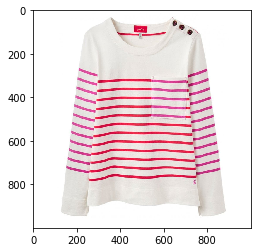

In [13]:
import cv2
from PIL import Image
out_path = './cropped/'
for category in category_list:
    for num,img_name in enumerate(img_list[category]):
        try:
            path = image_path+category+'/'+img_name
            image = os.path.join(path)
            img = Image.open(image).convert("RGB")
            plt.imshow(img)
            trans = transforms.ToTensor()
            img = trans(img)
            model.eval()
            with torch.no_grad():
                prediction = model([img.to(device)])
                
                
            rimg = img.mul(255).permute(1, 2, 0).byte().numpy()
            Image.fromarray(rimg)    

            b, g, r = cv2.split(rimg)   # img파일을 b,g,r로 분리
            rimg2 = cv2.merge([r,g,b])
            num_obj = len([x for x in prediction[0]['scores'].tolist() if x>0.6])
                
            for idx in range(num_obj):
                if prediction[0]['labels'][idx].tolist() == 1:
                    boxes = prediction[0]['boxes'][idx]
                    labels = prediction[0]['labels'][idx].tolist()

                    minx, miny, maxx, maxy = int(boxes[0]),int(boxes[1]),int(boxes[2]),int(boxes[3])

                    cropping = rimg2[miny:maxy, minx:maxx]
                    cv2.imwrite('./cropped/'+category+'/'+str(num) + '_' + str(idx)+'.jpg', cropping)
                
                
        except Exception:
            continue
        


